In [3]:
#!usr/bin/env python
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

"""
The goal here is to try different methods in time series forecasting

Get the data here: https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/
"""

In [4]:
training = pd.read_csv("ts_train.csv")
testing = pd.read_csv("ts_test.csv")

training = training.drop('ID', 1)
testing = testing.drop('ID', 1)

print training.head()
print training.tail()
print testing.head()
print testing.tail()

           Datetime  Count
0  25-08-2012 00:00      8
1  25-08-2012 01:00      2
2  25-08-2012 02:00      6
3  25-08-2012 03:00      2
4  25-08-2012 04:00      2
               Datetime  Count
18283  25-09-2014 19:00    868
18284  25-09-2014 20:00    732
18285  25-09-2014 21:00    702
18286  25-09-2014 22:00    580
18287  25-09-2014 23:00    534
           Datetime
0  26-09-2014 00:00
1  26-09-2014 01:00
2  26-09-2014 02:00
3  26-09-2014 03:00
4  26-09-2014 04:00
              Datetime
5107  26-04-2015 19:00
5108  26-04-2015 20:00
5109  26-04-2015 21:00
5110  26-04-2015 22:00
5111  26-04-2015 23:00


In [5]:
# As we can see, the raw data is count hourly, let's generate daily basic count using median
training.Timestamp = pd.to_datetime(training.Datetime,format='%d-%m-%Y %H:%M') 
training.index = training.Timestamp 
training = training.resample('D').median()  # this method will group by index for each numerical col

testing.Timestamp = pd.to_datetime(testing.Datetime,format='%d-%m-%Y %H:%M') 
testing.index = testing.Timestamp

In [6]:
print training.head()
print testing.head()

            Count
Datetime         
2012-08-25      2
2012-08-26      4
2012-08-27      2
2012-08-28      2
2012-08-29      2
                             Datetime
Datetime                             
2014-09-26 00:00:00  26-09-2014 00:00
2014-09-26 01:00:00  26-09-2014 01:00
2014-09-26 02:00:00  26-09-2014 02:00
2014-09-26 03:00:00  26-09-2014 03:00
2014-09-26 04:00:00  26-09-2014 04:00


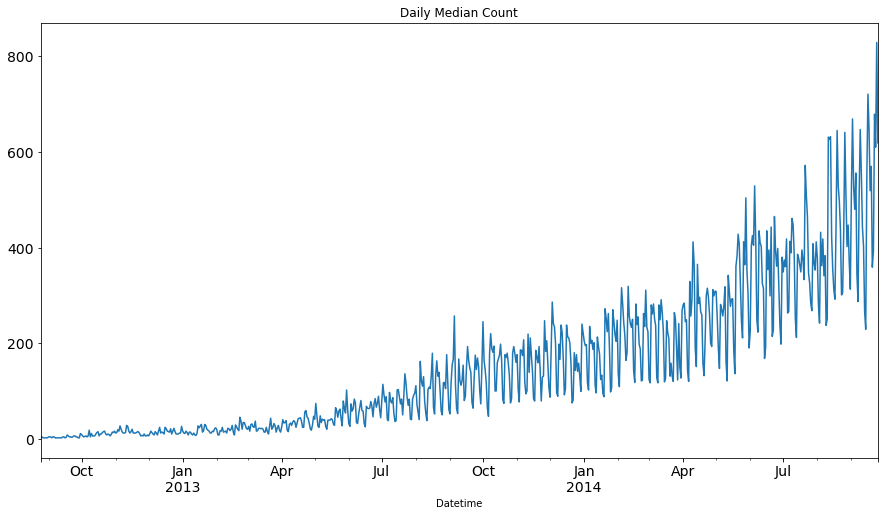

In [7]:
#Plotting data
training['Count'].plot(figsize=(15,8), title= 'Daily Median Count', fontsize=14)
plt.show()

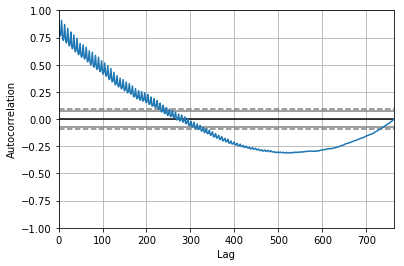

In [8]:
autocorrelation_plot(training)
plt.show()

In [9]:
# BEFORING USING ANY FOREBASTING MODELS, check stationary first
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(9,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='green', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')  # must be 1-array data here
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

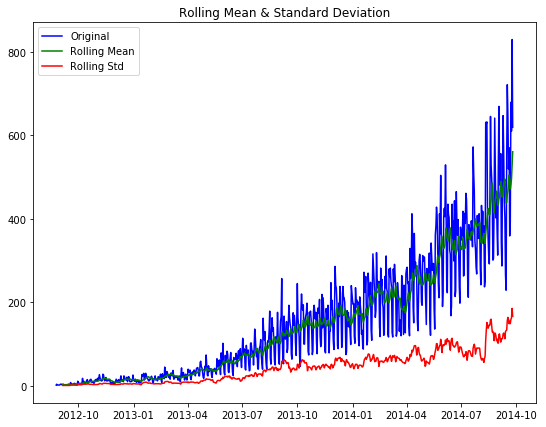

Results of Dickey-Fuller Test:
Test Statistic                   3.329567
p-value                          1.000000
#Lags Used                      20.000000
Number of Observations Used    741.000000
Critical Value (5%)             -2.865448
Critical Value (1%)             -3.439206
Critical Value (10%)            -2.568851
dtype: float64


In [10]:
test_stationarity(training)

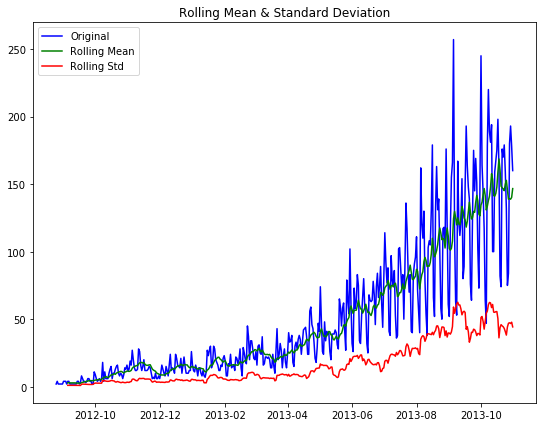

Results of Dickey-Fuller Test:
Test Statistic                   1.231239
p-value                          0.996195
#Lags Used                      16.000000
Number of Observations Used    416.000000
Critical Value (5%)             -2.868513
Critical Value (1%)             -3.446168
Critical Value (10%)            -2.570484
dtype: float64


In [11]:
df = pd.read_csv('ts_train.csv', nrows = 11856)
train=df[0:10392] 
test=df[10392:]
train = train.drop('ID', 1)
test = test.drop('ID', 1)

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').median()

test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').median()

test_stationarity(train)

# This is NOT stationary, mean changes overtime, variance changes indicates that the trend is not stable
## but the absolute Test Statistical is lower than all the absolute Critical Value
## p-value is not small
## non-stationary

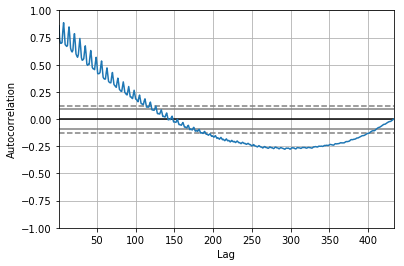

In [12]:
autocorrelation_plot(train)
plt.show()

# Looks like an AR model? Since the shocks didn't vanish along the time, but has more lasting effect after the shocks

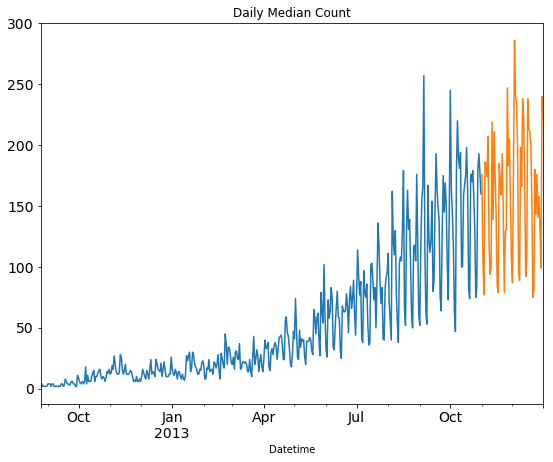

In [13]:
# Anyway, here, let's try to use the train & test data here

#Plotting data
train['Count'].plot(figsize=(9,7), title= 'Daily Median Count', fontsize=14)
test['Count'].plot(figsize=(9,7), title= 'Daily Median Count', fontsize=14)
plt.show()

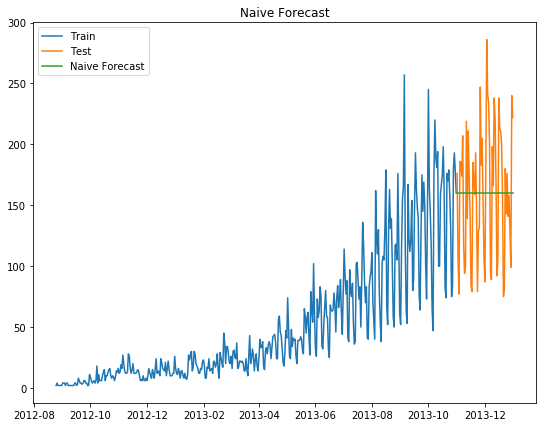

53.2291674019


In [14]:
# method 1 - Previous day = next day (I think this idea is so stupid, you even no need to plot
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(9,7))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)  # RMSE

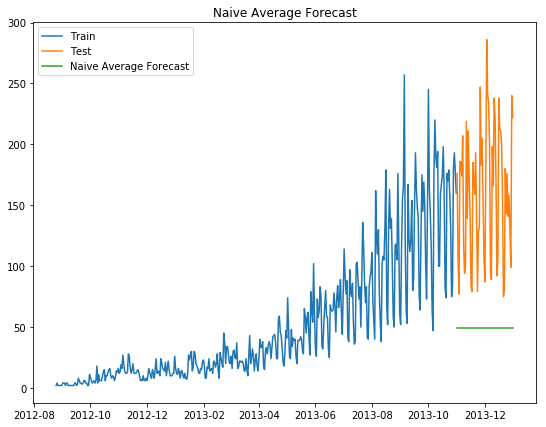

123.611662189


In [15]:
# Mehtod 2 - Average all training data (this idea is also stupid)
y_hat = test.copy()
y_hat['naive_avg'] = train['Count'].mean()

plt.figure(figsize=(9,7))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive_avg'], label='Naive Average Forecast')
plt.legend(loc='best')
plt.title("Naive Average Forecast")
plt.show()


rms = sqrt(mean_squared_error(test.Count, y_hat.naive_avg))
print(rms)

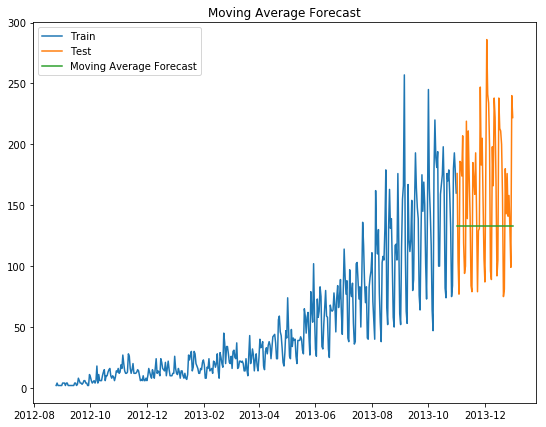

60.2231728827


In [16]:
# Method 3 - Moving Average (sliding window of size k)
k = 79
y_hat = test.copy()
y_hat['moving_avg'] = train['Count'].rolling(k).mean().iloc[-1]  # the mean of the k-size sliding window

plt.figure(figsize=(9,7))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['moving_avg'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title("Moving Average Forecast")
plt.show()


rms = sqrt(mean_squared_error(test.Count, y_hat.moving_avg))
print(rms)

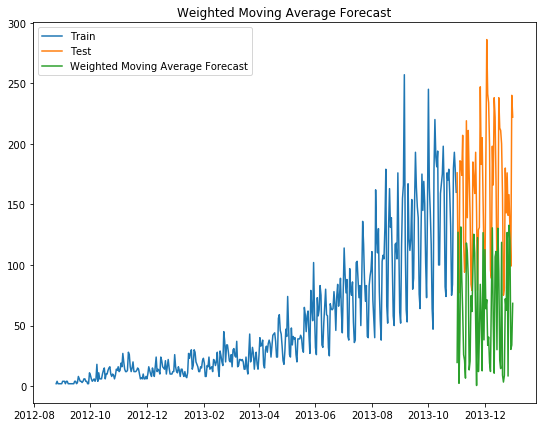

117.906311995


In [20]:
# You can also try weighted moving average (I'm wondering, if you know how to weight, do you even need to forecast)
import random

random.seed(410)
k = 79
y_hat = test.copy()
y_hat['moving_avg'] = train['Count'].rolling(k).mean().iloc[-1]
random_weights = [random.uniform(0, 1) for i in range(len(y_hat['moving_avg']))]
y_hat['weighted_moving_avg'] = [y_hat['moving_avg'][i]*random_weights[i] for i in range(len(y_hat['moving_avg']))]

plt.figure(figsize=(9,7))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['weighted_moving_avg'], label='Weighted Moving Average Forecast')
plt.legend(loc='best')
plt.title("Weighted Moving Average Forecast")
plt.show()


rms = sqrt(mean_squared_error(test.Count, y_hat.weighted_moving_avg))
print(rms)

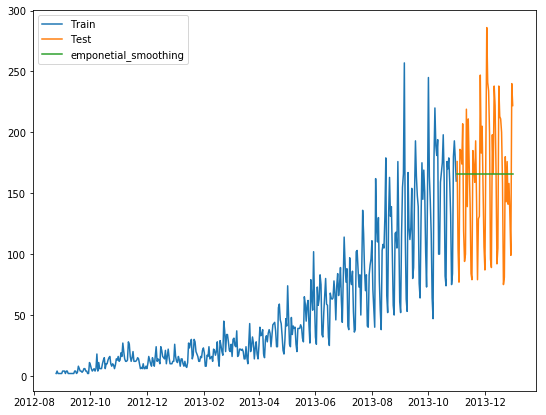

53.4171563148


In [34]:
# Method 4 - Exponetial Smoothing
##  The idea is: the weights will decrease from the latest to the oldest data
## Yt+1 = α*Yt + α(1-α)*Yt-1 + α(1-α)(1-α)*Yt-2 + ... + α*pow(1-α, n)*Yt-n, α is in [0,1] range

y_hat = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.7,optimized=False)
y_hat['emponetial_smoothing'] = fit2.forecast(len(test))
plt.figure(figsize=(9,7))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat['emponetial_smoothing'], label='emponetial_smoothing')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(test.Count, y_hat.emponetial_smoothing))
print(rms)

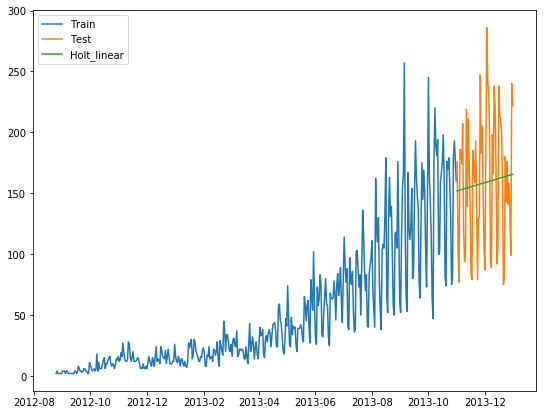

52.9330019642


In [39]:
# Method 5 - Holt’s Linear Trend
## This method helps to decompose the tie series into trend, seasonality and residual
## It applies exponential smoothing to both Level data and Trend data
## Level data - the average value in the series
## Each equation here is exponential smoothing
## Additive method - Forecast result = Trent Equation + Level Equation
## Multiplication method - Forecast result = Trent Equation*Level Equation
## Below is neither additive nor multiplication, but linear


y_hat = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.1,smoothing_slope = 0.1)
y_hat['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(9,7))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(test.Count, y_hat.Holt_linear))
print(rms)

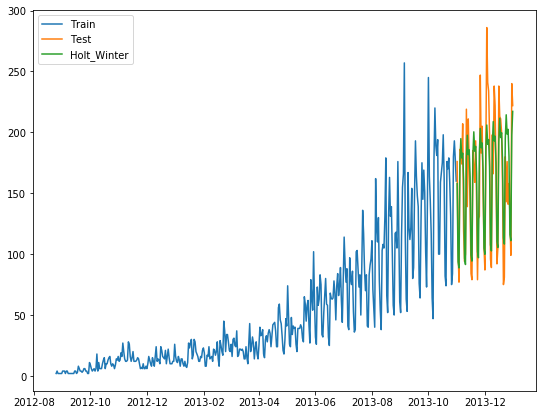

29.4953002166


In [42]:
# Method 6 - Holt-Winters
## It considers both trend and seasonality
## Each equation here is exponential smoothing
## Additive method - Forecast result = Trent Equation + Level Equation + Seasonality Equation
## Multiplication method - Forecast result = Trent Equation*Level Equation*Seasonality Equation

y_hat = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(9,7))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(test.Count, y_hat.Holt_Winter))
print(rms)

In [ ]:
"""
Multiplicative maybe better: http://www.forsoc.net/2014/11/11/can-you-identify-additive-and-multiplicative-seasonality/
But dropping NA is troublesome here
"""

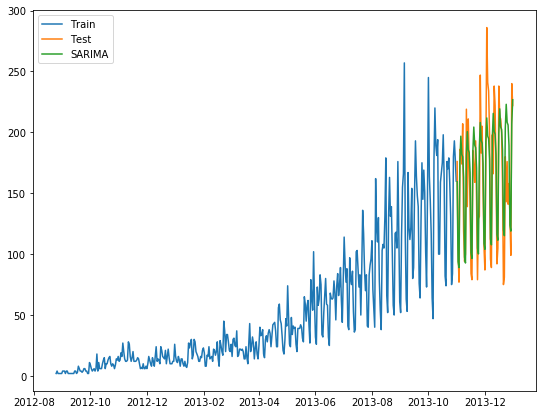

30.4487961209


In [69]:
# Method 7 - Seasonal ARIMA
# ARIMA is trying to tell the correlations between the data
## Seasonal ARIMA takes into account the seasonality
from statsmodels.tsa.statespace.sarimax import SARIMAX

y_hat = test.copy()
# seasonal_order means (p,d,q,s), p,d,q are the same for ARIMA order, s means seasonal, 12-monthly, 4-quanrterly
fit1 = SARIMAX(train.Count, order=(0, 1, 1),seasonal_order=(0,1,1,7)).fit()  # order means (p,d,q) for ARIMA
y_hat['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(9,7))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(test.Count, y_hat['SARIMA']))
print(rms)